Λαμπρόπουλος Κωνσταντίνος
$$ $$
AM:1115201800092

Imports

In [66]:
from IPython.display import display,Math,Latex
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import ConfusionMatrix,F1Score
import matplotlib.pyplot as plt 

Question 1 : FeedForward Neural Network

Load Datasets

In [2]:
#Load Train set
X_train = np.load('./music_genre_data_di/train/mfccs/X.npy') #Load mfccs values
Labels_train = np.load('./music_genre_data_di/train/mfccs/labels.npy')#Load train set labels

#Load Validation set
X_val = np.load('./music_genre_data_di/val/mfccs/X.npy')#Load mfccs values
Labels_val = np.load('./music_genre_data_di/val/mfccs/labels.npy')#Load validation set labels

#Load Test set
X_test = np.load('./music_genre_data_di/test/mfccs/X.npy')#Load mfccs values
Labels_test = np.load('./music_genre_data_di/test/mfccs/labels.npy')#Load test set labels

Encode the labels

In [3]:
encoder  = LabelEncoder() #initialize label encoder so we can set integer values to the label unique values

#encode all label sets
Labels_train_encoded = encoder.fit_transform(Labels_train)
Labels_val_encoded = encoder.fit_transform(Labels_val)
Labels_test_encoded = encoder.fit_transform(Labels_test) 

Create torch Datasets

In [4]:
batch_size = 16

#Train set
X_train_tensor = torch.tensor(X_train,dtype=torch.float32) #create a torch tensor for the mfccs values from the numpy array
Labels_train_tensor = torch.tensor(Labels_train_encoded,dtype=torch.long) #create a torch tensor for the labels from the numpy array
Dataset = TensorDataset(X_train_tensor,Labels_train_tensor) #Create a dataset
Train_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the train set

#Val set
X_val_tensor = torch.tensor(X_val,dtype=torch.float32) #create a torch tensor for the mfccs values from the numpy array
Labels_val_tensor = torch.tensor(Labels_val_encoded,dtype=torch.long) #create a torch tensor for the labels from the numpy array
Dataset = TensorDataset(X_val_tensor,Labels_val_tensor) #Create a dataset
Validation_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the validation set

#Test set 
X_test_tensor = torch.tensor(X_test,dtype=torch.float32) #create a torch tensor for the mfccs values from the numpy array
Labels_test_tensor = torch.tensor(Labels_test_encoded,dtype=torch.long) #create a torch tensor for the labels from the numpy array
Dataset = TensorDataset(X_test_tensor,Labels_test_tensor) #Create a dataset
Test_set = DataLoader(Dataset,batch_size=batch_size) #Create the test set

Set CPU or GPU

In [5]:
if torch.cuda.is_available(): #if nvidia gpu is available
   device="cuda" #set devide to cuda since GPUs are much faster at deep learning
else: 
   device="cpu" #else set CPU
print("Device =",device)

Device = cuda


Create Feed Forward Neural Network Class

In [6]:
class FeedForwardNeuralNetwork(nn.Module):
    def __init__(self): #initialize feedforward network
        super(FeedForwardNeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential( #Initialize the linear layers
            nn.Linear(26,128),
            nn.ReLU(),
            nn.Linear(128,32),
            nn.ReLU(),
            nn.Linear(32,4), #output is 4 since we have 4 music classes
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x) #pass the mfccs value through the network
        return logits #return the output
    
model = FeedForwardNeuralNetwork().to(device) #Create a feedforward network instance

In [7]:
def Train(dataLoader,model,loss_fn,optimizer,scheduler1 = None,scheduler2 = None):
    size = len(dataLoader.dataset) #Get the size of the dataset
    for batch, (X,y) in enumerate(dataLoader): #iterate all the dataset

        X = X.to(device) #Load variables to GPU
        y = y.to(device) #Load variables to GPU

        pred = model(X) #predict the label
        loss = loss_fn(pred,y) #find the loss between the prediction and the true label

        #BackPropagation
        optimizer.zero_grad() #reset all the gradients
        loss.backward()
        optimizer.step() #perform a step

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    if scheduler1: #if there is a scheduler available
        scheduler1.step() #get the next learning rate
    if scheduler2: #if there are chained schedulers
        scheduler2.step() #get the next learning rate


In [8]:
def Test(dataloader,model,loss_fn):
    size = len(dataloader.dataset) #get the size of the dataset
    test_loss,correct,f1 = 0,0,0 #declare variables
    f1_score = F1Score(task='multiclass',num_classes=4,average='macro').to(device) 

    with torch.no_grad(): #disable gradient caclulation since we are testing not training
        for X,y in dataloader:

            X = X.to(device) #Load to GPU
            y = y.to(device) #Load to GPU

            pred = model(X) #predict the label

            test_loss += loss_fn(pred,y).item() #find the loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() #find the accuracy
            f1 += f1_score(pred.argmax(1),y) #find the f1 score

    test_loss /= size #compute the average loss
    correct /= size #average accuracy
    f1 /= size #average f1 score
    confmat = ConfusionMatrix('multiclass',num_classes=4).to(device)
    confusion_matrix = confmat(pred.argmax(1),y) #find the confusion matrix
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f},Avg F1-Score: {f1:>8f}\n") #print statistics
    print(f"Confusion Matrix \n: {confusion_matrix}\n") #print confusion matrix

In [9]:
def Validation(dataloader,model):
    size = len(dataloader.dataset) #get the size of the dataset
    f1 = 0 #declare f1 score to 0
    f1_score = F1Score(task='multiclass',num_classes=4,average='macro').to(device)

    with torch.no_grad(): #disable gradient caclulation since we are validating not training
        for X,y in dataloader:

            X = X.to(device)#Load to GPU
            y = y.to(device)#Load to GPU

            pred = model(X) #predict the label
            f1 += f1_score(pred.argmax(1),y) #calculate the f1 score
    f1 /= size #find the average f1 score
    return f1

In [10]:
loss_fn = nn.CrossEntropyLoss() #set loss function
best_f1 = 0 #initialize variables
learning_rate = 0.002

optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate) #set optimizer

epochs_count = 30 #set epochs count

for t in range(epochs_count): #iterate over the entire dataset for the number of epochs specified
    print(f"Epoch {t+1}\n-------------------------------")
    Train(Train_set,model,loss_fn,optimizer) #train the model
    f1 = Validation(Validation_set,model) #find the f1 score for the validation set
    if f1 >= best_f1: #if the f1 score of the validation set is the best one
        best_f1 = f1 #set it to the best f1 variable
        best_model = model #set best model equal to the current model
print("Best Model computed by finding the model with the highest f1 score on the validation set\n")
Test(Test_set,best_model,loss_fn)#test based on the best model found by the validation set

Epoch 1
-------------------------------
loss: 1.355843  [    0/ 3200]
loss: 1.397400  [ 1600/ 3200]
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.087197,Avg F1-Score: 0.003701

Confusion Matrix 
: tensor([[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [16,  0,  0,  0]], device='cuda:0')

Epoch 2
-------------------------------
loss: 1.333592  [    0/ 3200]
loss: 1.388485  [ 1600/ 3200]
Test Error: 
 Accuracy: 36.8%, Avg loss: 0.085870,Avg F1-Score: 0.007089

Confusion Matrix 
: tensor([[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0, 13,  3,  0]], device='cuda:0')

Epoch 3
-------------------------------
loss: 1.407745  [    0/ 3200]
loss: 1.356809  [ 1600/ 3200]
Test Error: 
 Accuracy: 39.0%, Avg loss: 0.085419,Avg F1-Score: 0.007854

Confusion Matrix 
: tensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [7, 0, 6, 3]], device='cuda:0')

Epoch 4
-------------------------------
loss: 1.349163  [    0/ 3

GPU vs CPU runtime

* Με την χρήση CPU για την αξιολόγηση του μοντέλου πετυχαίνουμε 60.6% accuracy,Loss 0.060977 και f1  0.011394 σε 6.5s
* Με την χρήση GPU για την αξιολόγιση του μοντέλου πετυχαίνουμε 62.4% accuracy,Loss 0.061011 και f1  0.011620 σε 22.4s

Question 2 : Convolutional Neural Network

Set Seed

In [45]:
import random
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import torch.backends.cudnn

SEED = 12345 #set a random seed
rs = RandomState(MT19937(SeedSequence(SEED))) #set random state
random.seed(SEED) #set seed to random
torch.manual_seed(SEED) #to torch
g_cuda = torch.Generator(device=device)
torch.cuda.manual_seed(SEED) #to the gpu
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed Worker

In [46]:
def seed_worker(worker_id): #function to seed each worker working on the dataset creation
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Load the datasets

In [47]:
#Load Train set
X_train = np.load('./music_genre_data_di/train/melgrams/X.npy')
Labels_train = np.load('./music_genre_data_di/train/melgrams/labels.npy')

#Load Validation set
X_val = np.load('./music_genre_data_di/val/melgrams/X.npy')
Labels_val = np.load('./music_genre_data_di/val/melgrams/labels.npy')

#Load Test set
X_test = np.load('./music_genre_data_di/test/melgrams/X.npy')
Labels_test = np.load('./music_genre_data_di/test/melgrams/labels.npy')

Encode the labels

In [48]:
encoder  = LabelEncoder() #initialize label encoder

Labels_train_encoded = encoder.fit_transform(Labels_train) #encode train labels to distinct integer values

Labels_val_encoded = encoder.fit_transform(Labels_val) #encode validation labels to distinct integer values

Labels_test_encoded = encoder.fit_transform(Labels_test) #encode test labels to distinct integer values

Create Torch Datasets

In [49]:
batch_size = 8
g = torch.Generator()
g.manual_seed(0)

#Train set
X_train_tensor = torch.tensor(X_train,dtype=torch.float32) #create a tensor from the melgrams
X_train_tensor = X_train_tensor.unsqueeze(1)
Labels_train_tensor = torch.tensor(Labels_train_encoded,dtype=torch.long) #create a tensor from the labels
Dataset = TensorDataset(X_train_tensor,Labels_train_tensor) #create a dataset
Train_set = DataLoader(Dataset,batch_size=batch_size,worker_init_fn=seed_worker,generator=g) #create a dataloader using the seed created above

#Val set
X_val_tensor = torch.tensor(X_val,dtype=torch.float32) #create a tensor from the melgrams
X_val_tensor = X_val_tensor.unsqueeze(1)
Labels_val_tensor = torch.tensor(Labels_val_encoded,dtype=torch.long) #create a tensor from the labels
Dataset = TensorDataset(X_val_tensor,Labels_val_tensor) #create a dataset
Validation_set = DataLoader(Dataset,batch_size=batch_size,worker_init_fn=seed_worker,generator=g) #create a dataloader using the seed created above

#Test set
X_test_tensor = torch.tensor(X_test,dtype=torch.float32) #create a tensor from the melgrams
X_test_tensor = X_test_tensor.unsqueeze(1)
Labels_test_tensor = torch.tensor(Labels_test_encoded,dtype=torch.long) #create a tensor from the labels
Dataset = TensorDataset(X_test_tensor,Labels_test_tensor) #create a dataset
Test_set = DataLoader(Dataset,batch_size=batch_size,worker_init_fn=seed_worker,generator=g) #create a dataloader using the seed created above

Create Convolutional Neural Network Class

In [50]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, dropout_rate=0.5): #initialize Convolutional Network
        super(ConvolutionalNeuralNetwork, self).__init__()
        kernel_size, padding = 5, 2 #set variables
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=kernel_size,padding=padding) #set convolutional layer
        self.bn1 = nn.BatchNorm2d(16) #set batch norm with out_features param equal to the out channels of each convolutional layer
        self.maxpool = nn.MaxPool2d(kernel_size=2) #initialize max pooling
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_size,padding=padding) #set convolutional layer
        self.bn2 = nn.BatchNorm2d(32) #set batch norm with out_features param equal to the out channels of each convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size,padding=padding) #set convolutional layer
        self.bn3 = nn.BatchNorm2d(64) #set batch norm with out_features param equal to the out channels of each convolutional layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size,padding=padding) #set convolutional layer
        self.bn4 = nn.BatchNorm2d(128) #set batch norm with out_features param equal to the out channels of each convolutional layer

        self.fc1 = nn.Linear(1024, 1024) #initialize fully connected layer
        self.dropout1 = nn.Dropout(dropout_rate) #set for each fully connected layer the dropout rate
        self.fc2 = nn.Linear(1024, 256) #initialize fully connected layer
        self.dropout2 = nn.Dropout(dropout_rate) #set for each fully connected layer the dropout rate
        self.fc3 = nn.Linear(256, 32) #initialize fully connected layer
        self.dropout3 = nn.Dropout(dropout_rate) #set for each fully connected layer the dropout rate
        self.fc4 = nn.Linear(32, 4) #initialize fully connected layer,output is 4 since we have 4 classes of music genres

    def forward(self, x):
        x = self.maxpool(F.elu(self.bn1(self.conv1(x)))) #pass the value through the convo layers
        x = self.maxpool(F.elu(self.bn2(self.conv2(x)))) #pass the value through the convo layers
        x = self.maxpool(F.elu(self.bn3(self.conv3(x)))) #pass the value through the convo layers
        x = self.maxpool(F.elu(self.bn4(self.conv4(x)))) #pass the value through the convo layers

        x = torch.flatten(x,1) #flatten the tensor

        x = F.elu(self.fc1(x)) #pass the value through each of the fully connected layerss
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = self.fc4(x)

        return x
model = ConvolutionalNeuralNetwork(dropout_rate=0.5).to(device) #initialize a convo neural network instance


In [51]:
loss_fn = nn.CrossEntropyLoss() #initialize loss function
best_f1 = 0 #initialize variables
learning_rate = 2e-3
patience = 0
epochs_count = 60
patience_tol = epochs_count

optimizer = torch.optim.Adagrad(model.parameters(),lr=learning_rate,weight_decay=1e-7) #initialize optimizer
scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,verbose=True,T_max=100) #initialize first scheduler
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9,verbose=True) #and second scheduler

for t in range(epochs_count): #iterate over the number of epochs
    print(f"Epoch {t+1}\n-------------------------------")
    torch.cuda.synchronize()
    Train(Train_set,model,loss_fn,optimizer,scheduler1,scheduler2) #train the convo network
    f1 = Validation(Validation_set,model) #find the current f1 score
    if f1 >= best_f1: #if it the best one yet
        best_f1 = f1 #set it as the best one
        best_model = model #this is the best model yet
    else:
        patience+=1 #else increment patience
    if patience == patience_tol: #if we have iterated over a number of epochs and still the model we found is the best one
        break #break from the iteration
print("Best Model computed by finding the model with the highest f1 score on the validation set\n")
Test(Test_set,best_model,loss_fn) #print the best model found

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 1
-------------------------------
loss: 1.354813  [    0/ 3200]
loss: 11.222861  [  800/ 3200]
loss: 9.694426  [ 1600/ 3200]
loss: 8.319596  [ 2400/ 3200]
Adjusting learning rate of group 0 to 1.9995e-03.
Adjusting learning rate of group 0 to 1.7996e-03.
Epoch 2
-------------------------------
loss: 11.757658  [    0/ 3200]
loss: 7.089171  [  800/ 3200]
loss: 7.519851  [ 1600/ 3200]
loss: 6.419196  [ 2400/ 3200]
Adjusting learning rate of group 0 to 1.7982e-03.
Adjusting learning rate of group 0 to 1.6184e-03.
Epoch 3
-------------------------------
loss: 9.046476  [    0/ 3200]
loss: 6.026916  [  800/ 3200]
loss: 6.436285  [ 1600/ 3200]
loss: 5.650746  [ 2400/ 3200]
Adjusting learning rate of group 0 to 1.6164e-03.
Adjusting learning rate of group 0 to 1.4548e-03.
Epoch 4
-------------------------------
loss: 8.185740  [    0/ 3200]
loss: 5.720587  [  800/ 3200]
loss: 6.261148  [ 

GPU vs CPU runtime

* Στο GPU έτρεξε σε 1m1.6s και επέστρεψε βέλτιστο μοντέλο με accuracy 65.6% ,Avg loss: 0.132755,Avg F1-Score: 0.012216
* Στο CPU έτρεξε σε χρόνο 26m25.1s και επέστρεψε βέλτιστο μοντέλο με  Accuracy: 65.0%, Avg loss: 0.152512,Avg F1-Score: 0.012084

Pooling And Padding

* Με max pooling με kernel = 2,padding = 2 η επίδοση αυξήθηκε στο 70.9% σε χρόνο 25.1s

Optimizers:

$
\begin{array}{|c|c|c|c|}
\hline
\text{Optimizer} & \text{Accuracy} & \text{F1-Score} & \text{Time}\\
\hline
\text{SGD} & \text{70.9\%} & \text{0.012845} & \text{25.1s}\\
\hline
\text{Adadelta} & \text{72.6\%} & \text{0.013035} & \text{25.1s}\\
\hline
\text{Adagrad} & \text{75.7\%} & \text{0.013490} & \text{30.1s}\\
\hline
\text{Adam} & \text{41.1\%} & \text{0.008715} & \text{27.5s}\\
\hline
\text{AdamW} & \text{72.2\%} & \text{0.012843} & \text{26.7s}\\
\hline
\text{Adamax} & \text{72.0\%} & \text{0.012983} & \text{36.8s}\\
\hline
\text{ASGD} & \text{71.9\%} & \text{0.012984} & \text{25.9s}\\
\hline
\text{NAdam} & \text{71.4\%} & \text{0.012894} & \text{28.0s}\\
\hline
\text{RAdam} & \text{68.9\%} & \text{0.012647} & \text{28.3s}\\
\hline
\text{RMSprop} & \text{61.3\%} & \text{0.010841} & \text{25.0s}\\
\hline
\text{Rprop} & \text{63.2\%} & \text{0.012063} & \text{53.1s}\\
\hline
\end{array}
$

Optimizers Comparsion

* Την καλύτερη απόδοση την είχε ο αλγόριθμος Adagrad που πέτυχε accuracy 75.7% ,F1-Score 0.013490 σε χρόνο 30.1s.Υπάρχουν μεγάλες διαφορές στην επίδοση των αλγορίθμων με την μικρότερη να την έχει ο αλγόριθμος Adam με accuracy 41.1%,F1-Score 0.008715 σε χρόνο 27.5s.Αυτό είναι αναμενόμενο γιατί κάθε αλγόριθμος είναι διαφορετικός ως προς την σύγκλιση.

Question 3 : Improving Performance

Activators

$
\begin{array}{|c|c|c|}
\hline
\text{Activator} & \text{Accuracy} & \text{F1-Score}\\
\hline
\text{ReLu} & \text{23.5\%} & \text{0.003706}\\
\hline
\text{ELU} & \text{26.0\%} & \text{0.004639}\\
\hline
\text{HardShrink} & \text{23.5\%} & \text{0.003706}\\
\hline
\text{HardSigmoid} & \text{23.5\%} & \text{0.003706}\\
\hline
\text{HardTanh} & \text{23.5\%} & \text{0.003706}\\
\hline
\end{array}
$

Schedulers

$
\begin{array}{|c|c|c|}
\hline
\text{Scheduler} & \text{Accuracy} & \text{F1-Score}\\
\hline
\text{LinearLR} & \text{29.0\%} & \text{0.004536}\\
\hline
\text{PolynomialLR} & \text{29.0\%} & \text{0.004536}\\
\hline
\text{ExponentialLR} & \text{29.0\%} & \text{0.004536}\\
\hline
\text{CosineAnnealingLR} & \text{29.0\%} & \text{0.004536}\\
\hline
\text{CosineAnnealingLR + ExponentialLR} & \text{30.5\%} & \text{0.005588}\\
\hline
\end{array}
$

Batch Normalization

* Με την προσθήκη του Batch Normalization σε κάθε convolutional layer του Convolutional Netowrk οι επιδόσεις αυξήθηκαν,και είναι: Accuracy: 60.7%,F1-Score: 0.010627.

Regularization

* Weight Decay

$
\begin{array}{|c|c|c|}
\hline
\text{Weight Decay} & \text{Accuracy} & \text{F1-Score}\\
\hline
\text{0.5} & \text{29.0\%} & \text{0.004536}\\
\hline
\text{1e-2} & \text{52.3\%} & \text{0.009304}\\
\hline
\text{1e-3} & \text{51.9\%} & \text{0.009138}\\
\hline
\text{1e-4} & \text{61.9\%} & \text{0.010879}\\
\hline
\text{1e-5} & \text{57.6\%} & \text{0.010176}\\
\hline
\text{1e-7} & \text{55.6\%} & \text{0.009886}\\
\hline
\end{array}
$

* Weight Decay and Dropout Rate

$
\begin{array}{|c|c|c|c|}
\hline
\text{Weight Decay} & \text{Dropout Rate} & \text{Accuracy} & \text{F1-Score}\\
\hline
\text{1e-4} & \text{0} & \text{63.2\%} & \text{0.011532}\\
\hline
\text{1e-4} & \text{0.1} & \text{63.2\%} & \text{0.011532}\\
\hline
\text{1e-4} & \text{0.2} & \text{63.2\%} & \text{0.011532}\\
\hline
\text{1e-4} & \text{0.5} & \text{63.2\%} & \text{0.011532}\\
\hline
\text{1e-4} & \text{0.7} & \text{63.2\%} & \text{0.011532}\\
\hline
\text{1e-4} & \text{1.0} & \text{63.2\%} & \text{0.011532}\\
\hline
\end{array}
$

Batch Size

$
\begin{array}{|c|c|c|c|}
\hline
\text{Batch Size} & \text{Accuracy} & \text{F1-Score} & \text{Time}\\
\hline
\text{2} & \text{66.6\%} & \text{0.089510} & \text{9m26.8s}\\
\hline
\text{4} & \text{71.7\%} & \text{0.048821} & \text{5m25.7s}\\
\hline
\text{8} & \text{72.3\%} & \text{0.024948} & \text{2m50.1s}\\
\hline
\text{16} & \text{63.2\%} & \text{0.011532} & \text{1m17.9s}\\
\hline
\text{32} & \text{53.3\%} & \text{0.005186} & \text{39.9s}\\
\hline
\text{64} & \text{53.9\%} & \text{0.015037} & \text{22.7s}\\
\hline
\text{128} & \text{51.3\%} & \text{0.001545} & \text{13.5s}\\
\hline
\end{array}
$

* Παρατηρούμε ότι όσο αυξάνεται το batch size μέχρι το 8 ,αυξάνεται και το accuracy ,ενώ υποδιπλασιάζονται τα F1-score και ο χρόνος εκτέλεσης.Υπό τις βέλτιστες συνθήκες το καλύτερο Batch Size θα ήταν 4(δηλαδή χωρίς να λάβουμε υπόψιν τον χρόνο εκτέλεσης).Όμως μιάς και ο χρόνος εκτέλεσης μας νοιάζει,το βέλτιστο batch size είναι το 8.Πέραν αυτού μειώνεται και το accuracy κατα πολύ,και το χρονικό κέρδος δεν αξίζει για την μείωση της απόδοσης του μοντέλου.

Early Stopping

$
\begin{array}{|c|c|c|c|}
\hline
\text{Patience} & \text{Accuracy} & \text{F1-Score} & \text{Time}\\
\hline
\text{3} & \text{71.8\%} & \text{0.024816} & \text{1m54.1s}\\
\hline
\text{5} & \text{71.4\%} & \text{0.024731} & \text{2m5.5s}\\
\hline
\text{7} & \text{71.5\%} & \text{0.024747} & \text{2m9.3s}\\
\hline
\text{10} & \text{71.6\%} & \text{0.024794} & \text{2m33.0s}\\
\hline
\text{None} & \text{71.6\%} & \text{0.024794} & \text{2m32.3s}\\
\hline
\end{array}
$


* Παρατηρώντας τα δεδομένα,το βέλτιστο patience είναι το 3,το οποίο έχει και το βέλτιστο Accuracy και το βέλτιστο F1-Score και ολοκληρώνεται η εκτέλεση του μοντέλου σε λιγότερο χρόνο.

Testing

* Inference

In [52]:
def Map_Type(type): #convert the distinct integer values of the encoded labels back to their originals
    if type == 0 : type_str = 'blues'
    elif type == 1 : type_str = 'classical'
    elif type == 2 : type_str = 'hiphop'
    else : type_str = 'rock_metal_hardrock'
    return type_str

In [53]:
def TestYT(dataloader,model):
    pred = []
    music_percentage = {}
    with torch.no_grad(): #dont calculate gradients since model is trained
        for X,y in dataloader: #iterate over all the items of the dataloader
            X = X.to(device) #add input to GPU
            pred = model(X) #predict the label
            pred.append(pred.argmax(1)) #append the tesnor to list
    for tensor in pred: #for each tensor in the list
        types, counts = torch.unique(tensor, return_counts=True) # get all the unique types and their counts
        for type, count in zip(types, counts): #for all types,counts
            if type.item() in music_percentage: #if the type is in the dictionary
                music_percentage[type.item()] += count.item() #increment the type count by the counter value
            else:
                music_percentage[type.item()] = count.item() #else the item is not in the dictionary so initialize the value of the type
    total_sum = sum(music_percentage.values()) #find the total sum of all the music genres
    percentages = {type: count / total_sum * 100 for type, count in music_percentage.items()} #calculate the percentages    
    for type, percentage in percentages.items(): #print all of them
        print(f'Type: {Map_Type(type)}, Percentage: {percentage:.2f}%')
    return pred

In [93]:
def CreatePlot(music,X_tensor,X_labels):
    Plot = [] #a list for all the points in the plot
    for tensor in music : 
        for value in tensor: #break the tensor
            Plot.append(value.item()) #and append each value to the list
    plt.figure() #create figure
    plt.scatter(np.arange(X_tensor.size(0)),Plot,s=5) #scatter each second correspoding to each value
    plt.xticks(X_labels) #set labels
    plt.yticks(labels=['Blues','Classical','Hip-Hop','Rock'],ticks=[0,1,2,3])
    plt.ylabel('Music Type')
    plt.xlabel('Seconds')
    plt.show() #show plot

Modified youtube.py Functions

Imports

In [110]:
import os
import librosa
import warnings

window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21

In [103]:
def download_youtube(url,filename):
    command = f'yt-dlp -x --audio-format wav --audio-quality 0 --output {filename} --postprocessor-args "-ar 8000 -ac 1" ' + url + " --quiet"
    os.system(command)

In [104]:
def load_wav(filename):
    """Rea audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs

In [105]:
def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out

In [106]:
def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments

In [107]:
def youtube_to_melgram(url,filename):
    download_youtube(url,filename)
    melgrams = get_melgrams(filename)
    npy_name = filename[:len(filename) - 4] + '.npy'
    np.save(npy_name, melgrams)

In [113]:
youtube_to_melgram(url = 'https://www.youtube.com/watch?v=9E6b3swbnWg',filename="./Classical.wav")
youtube_to_melgram(url = "https://www.youtube.com/watch?v=EDwb9jOVRtU",filename="./HipHop.wav")
youtube_to_melgram(url = "https://www.youtube.com/watch?v=OMaycNcPsHI",filename="./Rock.wav")
youtube_to_melgram(url = "https://www.youtube.com/watch?v=l45f28PzfCI",filename="./Blues.wav")

Type: classical, Percentage: 98.15%
Type: rock_metal_hardrock, Percentage: 1.11%
Type: blues, Percentage: 0.37%
Type: hiphop, Percentage: 0.37%


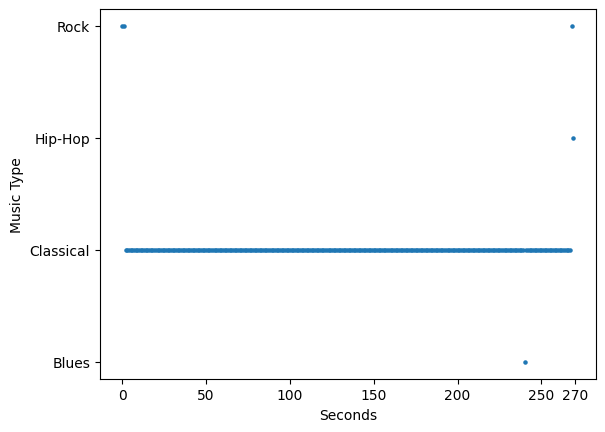

In [114]:
X = np.load('./Classical.npy') #load the first song
X_tensor = torch.tensor(X,dtype=torch.float32) #create a tensor from the melgrams
X_tensor = X_tensor.unsqueeze(1) 
y_tensor = torch.full((X_tensor.size(0),),0,dtype=torch.long) #create a second tensor in order to create a dataset
tensor_dataset = TensorDataset(X_tensor,y_tensor) #create the dataset
data = DataLoader(tensor_dataset,shuffle=False,batch_size=8) #create the dataloader instance
music = TestYT(data,model) #predict the music genre
X_labels = [0,50,100,150,200,250,270]
CreatePlot(music,X_tensor,X_labels)

* Για να θεωρήσουμε ότι ένα τραγούδι ανήκει σ'ένα είδος μουσικής αρκεί στο είδος αυτό να έχουμε accuracy $\geq$ 50.0%.Στο συγκεκριμένο τραγούδι έχουμε ακρίβεια της τάξης του 98.15%,επομένως σύμφωνα με τον ταξινομητή μας το τραγούδι ανήκει στο είδος της κλασικής μουσικής,το οποίο είναι αληθές.

Type: hiphop, Percentage: 53.89%
Type: rock_metal_hardrock, Percentage: 29.94%
Type: blues, Percentage: 9.88%
Type: classical, Percentage: 6.29%


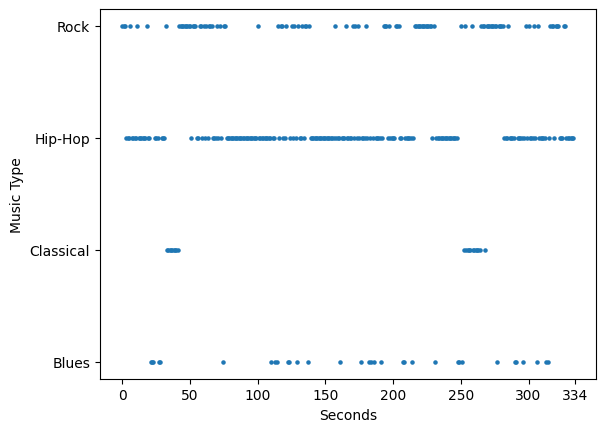

In [115]:
X = np.load('./HipHop.npy') #load the second song
X_tensor = torch.tensor(X,dtype=torch.float32) #create a tensor from the melgrams
X_tensor = X_tensor.unsqueeze(1) 
y_tensor = torch.full((X_tensor.size(0),),0,dtype=torch.long) #create a second tensor in order to create a dataset
tensor_dataset = TensorDataset(X_tensor,y_tensor) #create the dataset
data = DataLoader(tensor_dataset,shuffle=False,batch_size=8) #create the dataloader instance
music = TestYT(data,model) #predict the music genre
X_labels = [0,50,100,150,200,250,300,334]
CreatePlot(music,X_tensor,X_labels)

* Στο τραγούδι της Madonna,Hung up,βρήκε ως είδος του τραγουδιού με ακρίβεια 53.89%,το Hip-Hop,το οποίο είναι αληθές.Επομένως ταξινόμησε ορθά το τραγούδι.

Type: blues, Percentage: 22.36%
Type: classical, Percentage: 8.63%
Type: hiphop, Percentage: 14.70%
Type: rock_metal_hardrock, Percentage: 54.31%


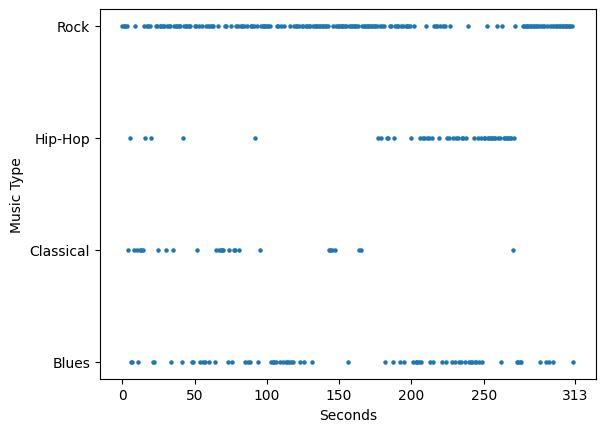

In [116]:
X = np.load('./Blues.npy')
X_tensor = torch.tensor(X,dtype=torch.float32)
X_tensor = X_tensor.unsqueeze(1)
y_tensor = torch.full((X_tensor.size(0),),0,dtype=torch.long)
tensor_dataset = TensorDataset(X_tensor,y_tensor)
data = DataLoader(tensor_dataset,shuffle=False,batch_size=8)
music = TestYT(data,model)
X_labels = [0,50,100,150,200,250,313]
CreatePlot(music,X_tensor,X_labels)

* Στο τραγούδι το BB-King,How Blue Can You Get,ταξινόμησε το τραγούδι ως κομμάτι της Rock με ακρίβεια της τάξης του 54.31%,το οποίο είναι ψευδές μιάς και ανήκει στο είδος των Blues.

Type: classical, Percentage: 4.17%
Type: rock_metal_hardrock, Percentage: 64.35%
Type: blues, Percentage: 26.39%
Type: hiphop, Percentage: 5.09%


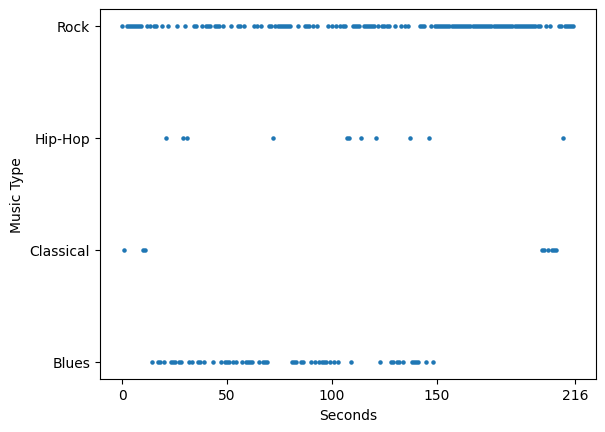

In [117]:
X = np.load('./Rock.npy')
X_tensor = torch.tensor(X,dtype=torch.float32)
X_tensor = X_tensor.unsqueeze(1)
y_tensor = torch.full((X_tensor.size(0),),0,dtype=torch.long)
tensor_dataset = TensorDataset(X_tensor,y_tensor)
data = DataLoader(tensor_dataset,shuffle=False,batch_size=8)
music = TestYT(data,model)
X_labels = [0,50,100,150,216]
CreatePlot(music,X_tensor,X_labels)

* Τέλος στο τραγούδι των Placebo,Every You Every Me,με ακρίβεια της τάξης του 64.35%,βρήκε ορθά ότι το είδος του τραγουδιού είναι Rock.

Συμπεράσματα

* Ο ταξινομητής μας,ταξινόμησε ορθά 3/4 τραγούδια που το δόθηκαν.Η ακρίβεια ταξινόμησης στο Test Set ήταν της τάξης του 72.3%,εδώ η ταξινόμηση μας είχε ακρίβεια 75%.Η μικρή διαφορά της τάξης του 2.7% θα εξομαλυνθεί αν χρησιμοποιήσουμε παραπάνω δείγματα από το Youtube,αφού ο δειγματικός μας χώρος στην μία περίπτωση περιέχει 1376 δείγματα ενώ ο άλλος 4.Επομένως αφού τα ποσοστά είναι αρκετά κοντά και η απόδοση και στα δύο Set είναι παρόμοια.

Λεπτομέρειες

* Οι υπολογισμοί σε όλα τα ερωτήματα έγιναν σε local PC ,με specs CPU: AMD R9 3900x και GPU : NVIDIA RTX 3080,επομένως οι χρόνοι εκτέλεσης μπορεί να διαφέρουν αρκετά από τους χρόνους εκτέλεσης του Notebook στο Colab.

* Η εργασία δοκιμάστηκε και τρέχει κανονικά στο google colab.

* Το αρχείο youtube.py αλλάχθηκε γιατί δεν λειτουργούσε το πρόγραμμα youtube_dl.Στη θέση αυτού τέθηκε το πρόγραμα yt-dlp.Επίσης οι αλλαγμένες συναρτήσεις του προστέθηκαν στο notebook για την διευκόλυνση της εξέτασης της εργασίας.